In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scanpy memory-profiler -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.3 MB/s eta 0:00:00


# Configuration Settings

This section defines the configuration parameters for training the model.

In [ ]:
config={
    'epoch':10000,
    'batch_size':256,
    'latent':2,
    'log':False,
    'scale':True,
    'patience':50
}

# Helper Functions

## Helper Functions

This section contains utility functions to assist with data visualization, clustering, and evaluation. Key functions include:

- `print_2D`: Generates a 2D scatter plot of data points colored by cluster labels, useful for visualizing cell embeddings.
- `print_heatmap`: Creates a heatmap to visualize the relationship between data points and features, with clustering of rows.
- `measure`: Calculates clustering quality metrics such as Normalized Mutual Information (NMI), Adjusted Rand Index (ARI), Homogeneity, and Completeness.
- `clustering`: Performs clustering (e.g., K-means or Spectral) on latent representations to identify cell types or groups.

These functions rely on libraries like `matplotlib`, `seaborn`, and `sklearn` for plotting and metrics computation.

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
import time

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, completeness_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

markers = {',': 'pixel', 'o': 'circle','*': 'star', 'v': 'triangle_down',
           '^': 'triangle_up', '<': 'triangle_left', '>': 'triangle_right',
           '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', '4': 'tri_right',
           '8': 'octagon', 's': 'square', 'p': 'pentagon',
           'h': 'hexagon1', 'H': 'hexagon2', '+': 'plus', 'x': 'x', '.': 'point',
           'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', '_': 'hline',
           'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft',
           1: 'tickright', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright',
           6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase', 10: 'caretupbase',
           11: 'caretdownbase', 'None': 'nothing', None: 'nothing', ' ': 'nothing', '': 'nothing'}
markers_keys = list(markers.keys())[:20]

font = {'family': 'normal', 'weight': 'bold', 'size': 30}
mpl.rc('font', **font)
sns.set_style("ticks")

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple",
          "royal blue", "lilac", "salmon", "bright turquoise", "dark maroon",
          "light tan", "orange", "orchid", "sandy", "topaz", "fuchsia", "yellow",
          "crimson", "cream"]
current_palette = sns.xkcd_palette(colors)

def print_2D(points, label, id_map):
    n_cell, _ = points.shape
    s = 10 if n_cell > 500 else 20

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.despine()

    unique_labels = np.unique(label)
    for i in unique_labels:
        ax.scatter(points[label == i, 0], points[label == i, 1], color=current_palette[i],
                   label=id_map[i], s=s, marker=markers_keys[i])

    ax.legend(scatterpoints=1, loc='lower center', bbox_to_anchor=(0.5, -0.15),
              ncol=6, fancybox=True, prop={'size': 8})
    ax.tick_params(axis='both', which='major', labelsize=8)

    timestamp = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig(f'result_2D_{timestamp}.svg')
    return fig

def print_heatmap(points, label, id_map):
    index = [id_map[i] for i in label]
    df = DataFrame(points, columns=list(range(points.shape[1])), index=index)
    row_color = [current_palette[i] for i in label]

    cmap = sns.cubehelix_palette(as_cmap=True, rot=-.3, light=1)
    g = sns.clustermap(df, cmap=cmap, row_colors=row_color, col_cluster=False,
                       xticklabels=False, yticklabels=False)
    return g.fig

def measure(predicted, true):
    NMI = normalized_mutual_info_score( true,predicted )
    print("NMI: "+str(NMI))
    ARI = adjusted_rand_score( true,predicted )
    print("ARI: "+str(ARI))
    HOM = homogeneity_score( true,predicted )
    print("Homogeneity: "+str(HOM))
    COM = completeness_score( true,predicted )
    print("Completeness: "+str(COM))
    return {'NMI': NMI, 'ARI': ARI, 'HOM': HOM, 'COM': COM}

def clustering(points, k=2, name='kmeans'):
    if name == 'kmeans':
        kmeans = KMeans(n_clusters=k, n_init=100).fit(points)
        labels = kmeans.labels_
    elif name == 'spectral':
        spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors').fit(points)
        labels = spectral.labels_

    if len(np.unique(labels)) > 1:
        si = silhouette_score(points, labels)

    return labels, si

# Model Implementation

This section defines the Variational Autoencoder for Single-Cell clustering (scInfoMaxVAE) model, which is designed to handle single-cell RNA sequencing data with zero inflation and dropout. Key components include:

- `VariationalLayer`: A custom Keras layer that combines reconstruction loss, KL divergence, and an optional discriminator loss for adversarial training.
- `scInfoMaxVAE` class: The main class that builds and trains the VAE, including encoder, decoder, latent sampling, and ZIFA layers for zero-inflated data modeling.
- Supporting functions (`sampling`, `sampling_gumbel`, `compute_softmax`, `gumbel_softmax`): Handle stochastic sampling and softmax operations for variational inference.

The model aims to reduce dimensionality while preserving biological structure for downstream clustering and visualization.

In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense, Activation, Lambda, RepeatVector, Concatenate, Reshape, Layer, Dropout, BatchNormalization, Permute, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from keras.models import Model
from keras import regularizers, metrics, ops
from keras.optimizers import RMSprop, Adagrad, Adam
import numpy as np
import h5py
import json
import os

tau = 1.0

def sampling(args):
    epsilon_std = 1.0

    if len(args) == 2:
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=K.shape(z_mean),
                              mean=0.,
                              stddev=epsilon_std)
        return z_mean + K.exp( z_log_var / 2 ) * epsilon
    else:
        z_mean = args[0]
        epsilon = K.random_normal(shape=K.shape(z_mean),
                              mean=0.,
                              stddev=epsilon_std)
        return z_mean + K.exp( 1.0 / 2 ) * epsilon


def sampling_gumbel(shape, eps=1e-8):
    u = K.random_uniform(shape, minval=0., maxval=1)
    return -K.log(-K.log(u+eps)+eps)

def compute_softmax(logits,temp):
    z = logits + sampling_gumbel( K.shape(logits) )
    return K.softmax( z / temp )

def gumbel_softmax(args):
    logits,temp = args
    y = compute_softmax(logits,temp)
    return y

In [ ]:
class Discriminator(tf.keras.Model):
    def __init__(self, z_dim=2, x_dim=784):
        super(Discriminator, self).__init__()
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.net = tf.keras.Sequential([
            layers.Dense(1000, activation='relu', input_shape=(self.x_dim + self.z_dim,)),
            layers.Dense(400, activation='relu'),
            layers.Dense(100, activation='relu'),
            layers.Dense(1)
        ])

    def call(self, inputs):
        x, z = inputs
        x = layers.Flatten()(x)
        combined = tf.concat([x, z], axis=1)
        output = self.net(combined)
        return tf.squeeze(output, axis=1)

def permute_dims_tf(z):
    batch_size = tf.shape(z)[0]
    perm = tf.random.shuffle(tf.range(batch_size))
    return tf.gather(z, perm)

In [ ]:
class VariationalLayer(tf.keras.layers.Layer):
    def __init__(self, in_dim, alpha=1.0, gamma=20.0, discriminator=None):
        super(VariationalLayer, self).__init__()
        self.in_dim = in_dim
        self.alpha = alpha
        self.gamma = gamma
        self.discriminator = discriminator

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var, z = inputs
        xent_loss = self.in_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        if self.discriminator:
            real_scores = self.discriminator([x, z])
            real_scores = tf.clip_by_value(real_scores, -10, 10)
            perm_z = permute_dims_tf(z)
            fake_scores = self.discriminator([x, perm_z])
            fake_scores = tf.clip_by_value(fake_scores, -10, 10)
            info_loss = -(K.mean(real_scores) - K.mean(K.exp(fake_scores - 1)))
        else:
            info_loss = 0.0
        total_loss = K.mean(xent_loss + self.alpha * kl_loss + self.gamma * info_loss)
        self.add_loss(total_loss)
        return x

class scInfoMaxVAE:
    def __init__(self, input_dim, hidden_dims, latent_dim=2, alpha=1.0, gamma=10.0):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.alpha = alpha
        self.gamma = gamma
        self.vae = None
        self.ae = None

    def build_encoder(self, input_layer):
        h = input_layer
        for i, dim in enumerate(self.hidden_dims):
            h = layers.Dense(dim, name=f'encoder_dense_{i}')(h)
            h = layers.BatchNormalization(name=f'encoder_bn_{i}')(h)
            h = layers.Activation('relu', name=f'encoder_act_{i}')(h)
        return h

    def build_latent(self, encoder_output):
        z_mean = layers.Dense(self.latent_dim, name='z_mean')(encoder_output)
        z_log_var = layers.Dense(self.latent_dim, name='z_log_var')(encoder_output)
        z_log_var = layers.Activation('softplus', name='z_log_var_softplus')(z_log_var)
        z = layers.Lambda(sampling, name='z_sampling')([z_mean, z_log_var])
        return z_mean, z_log_var, z

    def build_decoder(self, z):
        h = z
        for i, dim in enumerate(reversed(self.hidden_dims)):
            h = layers.Dense(dim, name=f'decoder_dense_{i}')(h)
            h = layers.BatchNormalization(name=f'decoder_bn_{i}')(h)
            h = layers.Activation('relu', name=f'decoder_act_{i}')(h)
        decoded = layers.Dense(self.input_dim, activation='sigmoid', name='decoded')(h)
        return decoded

    def build_zifa(self, decoded, temperature_input):
        x_drop = layers.Lambda(lambda x: -x ** 2, name='x_drop')(decoded)
        x_drop_p = layers.Lambda(lambda x: K.exp(x), name='x_drop_p')(x_drop)
        x_nondrop_p = layers.Lambda(lambda x: 1 - x, name='x_nondrop_p')(x_drop_p)
        x_nondrop_log = layers.Lambda(lambda x: K.log(x + 1e-20), name='x_nondrop_log')(x_nondrop_p)
        x_drop_log = layers.Lambda(lambda x: K.log(x + 1e-20), name='x_drop_log')(x_drop_p)
        logits = layers.Concatenate(axis=-1, name='logits')([x_drop_log, x_nondrop_log])
        temp_ = layers.Reshape((self.input_dim, 1))(temperature_input)
        samples = layers.Lambda(gumbel_softmax,
                        output_shape=lambda input_shapes: input_shapes[0],
                        name='gumbel_samples')([logits, temp_])
        samples = layers.Lambda(lambda x: x[:, :, 1],
                               output_shape=(self.input_dim,),
                               name='samples_nondrop')(samples)
        samples = layers.Reshape((self.input_dim,),
                                 name='samples_reshape')(samples)
        out = layers.Multiply(name='masked_output')([decoded, samples])
        return out

    def build(self):
        input_layer = layers.Input(shape=(self.input_dim,), name='input')
        temperature_input = layers.Input(shape=(self.input_dim,), name='temperature')

        encoder_output = self.build_encoder(input_layer)

        z_mean, z_log_var, z = self.build_latent(encoder_output)

        decoded = self.build_decoder(z)

        masked_output = self.build_zifa(decoded, temperature_input)

        discriminator = Discriminator(z_dim=self.latent_dim, x_dim=self.input_dim)

        variational_output = VariationalLayer(
            in_dim=self.input_dim,
            alpha=self.alpha,
            gamma=self.gamma,
            discriminator=discriminator
        )([input_layer, decoded, z_mean, z_log_var, z])

        self.vae = Model(inputs=[input_layer, temperature_input], outputs=variational_output)
        self.ae = Model(inputs=[input_layer, temperature_input], outputs=[z_mean, z, decoded])

        self.vae.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=None)
        return self.vae, self.ae

    def predict(self, input_data, mode='full', temperature=1.0):

        if self.ae is None:
            raise ValueError("Model has not been built yet.")

        temperature_input = np.ones_like(input_data) * temperature

        if mode == 'latent':
            z_mean = self.ae.predict([input_data, temperature_input])[0]
            return z_mean
        elif mode == 'reconstructed':
            _, _, reconstructed = self.ae.predict([input_data, temperature_input])
            return reconstructed
        elif mode == 'full':
            z_mean, z, reconstructed = self.ae.predict([input_data, temperature_input])
            return z_mean, z, reconstructed
        else:
            raise ValueError("Invalid mode. Choose from 'latent', 'reconstructed', 'full'.")

    def save(self, file_path):
        if not os.path.exists(file_path):
            os.makedirs(file_path)

        self.vae.save_weights(os.path.join(file_path, 'vae_weights.h5'))

        config = {
            'input_dim': self.input_dim,
            'hidden_dims': self.hidden_dims,
            'latent_dim': self.latent_dim,
            'alpha': self.alpha,
            'gamma': self.gamma
        }
        with open(os.path.join(file_path, 'config.json'), 'w') as f:
            json.dump(config, f)

    def load_weights(self, weights_path):
        if self.vae is None:
            raise ValueError("Model has not been built yet.")
        self.vae.load_weights(weights_path)

# Training Pipeline

This section outlines the pipeline for loading, preprocessing, and training the scInfoMaxVAE model on single-cell data. Key functions include:

- `preprocess`: Preprocesses the AnnData object by filtering low-count genes/cells, normalizing, scaling, and optionally log-transforming the data.
- `read_dataset`: Loads a single-cell dataset (e.g., `.h5ad` file) and optionally splits it into training and test sets.
- `scinfomax`: Trains the scInfoMaxVAE model on expression data, adjusting for zero inflation and monitoring loss and clustering performance.

The training process uses the configuration settings and helper functions to produce latent representations for clustering and visualization.

In [ ]:
def scinfomax(expr, epoch=5000, latent=2, patience=50, min_stop=500, batch_size=32, var=False, prefix='test',
         label=None, log=True, scale=True, annealing=False, tau0=1.0, min_tau=0.5, rep=0):
    expr = expr.copy()
    expr[expr < 0] = 0.0
    if log:
        expr = np.log2(expr + 1)
    if scale:
        for i in range(expr.shape[0]):
            max_val = np.max(expr[i,:])
            if max_val > 0:
                expr[i,:] = expr[i,:] / max_val
    if rep > 0:
        expr_train = np.matlib.repmat(expr, rep, 1)
    else:
        expr_train = np.copy(expr)

    input_dim = expr.shape[1]
    hidden_dims = [512, 128, 32]
    vae_ = scInfoMaxVAE(input_dim=input_dim,
                hidden_dims=hidden_dims,
                latent_dim=latent)
    vae_.build()

    points = []
    loss_list = []
    prev_loss = np.inf
    tau = tau0
    anneal_rate = 0.0003
    for e in range(epoch):
        cur_loss = prev_loss
        if e % 100 == 0 and annealing:
            tau = max(tau0 * np.exp(-anneal_rate * e), min_tau)
            print(f"Temperature: {tau}")
        tau_in = np.ones(expr_train.shape, dtype='float32') * tau
        history = vae_.vae.fit([expr_train, tau_in], expr_train,
                               epochs=1,
                               batch_size=batch_size,
                               shuffle=True,
                               verbose=0)
        train_loss = history.history['loss'][0]
        cur_loss = min(train_loss, cur_loss)
        loss_list.append(train_loss)
        res = vae_.ae.predict([expr, tau_in])
        points.append(res[0])  # res[0] is z_mean
        if label is not None:
            k = len(np.unique(label))
        if e % patience == 1:
            print(f"Epoch {e+1}/{epoch}")
            print(f"Loss: {train_loss}")
            if abs(cur_loss - prev_loss) < 1 and e > min_stop:
                break
            prev_loss = train_loss
            if label is not None:
                try:
                    cl, _ = clustering(res[0], k=k)
                    measure(cl, label)
                except:
                    print('Clustering error')

    return res[0], vae_

# Model Training and Visualization

This section executes the training of the scInfoMaxVAE model on a specific dataset (`camp1.h5ad`) and visualizes the results. Steps include:

- Loading the dataset from Google Drive and preprocessing it to prepare for training.
- Training the scInfoMaxVAE model with the specified configuration, monitoring loss, and evaluating clustering quality using metrics like NMI and ARI.
- Visualizing the 2D latent space using `print_2D` to show cell type clustering, with each point colored by its label.
- Saving the latent representations back to the AnnData object for further analysis.

The output includes training progress, clustering metrics, and a scatter plot, demonstrating the model's effectiveness in identifying cell types.

In [ ]:
import scanpy as sc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [ ]:
def read_dataset(adata, transpose=False, test_split=False, copy=False, check_counts=True):
    if isinstance(adata, sc.AnnData):
        if copy:
            adata = adata.copy()
    elif isinstance(adata, str):
        adata = sc.read(adata)
    else:
        raise NotImplementedError

    adata.X = adata.X.astype(float)

    if transpose: adata = adata.transpose()

    if test_split:
        train_idx, test_idx = train_test_split(np.arange(adata.n_obs), test_size=0.1, random_state=42)
        spl = pd.Series(['train'] * adata.n_obs)
        spl.iloc[test_idx] = 'test'
        adata.obs['split'] = spl.values
    else:
        adata.obs['split'] = 'train'

    adata.obs['split'] = adata.obs['split'].astype('category')
    return adata

In [ ]:
def preprocess(adata, filter_low_counts=True, calc_size_factors=True, scale_data=True, log_transform=True):
    if filter_low_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)

    if calc_size_factors or scale_data or log_transform:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if calc_size_factors:
        sc.pp.normalize_total(adata)
        adata.obs['size_factors'] = adata.obs['n_counts'] / np.median(adata.obs['n_counts'])
    else:
        adata.obs['size_factors'] = 1.0

    if log_transform:
        sc.pp.log1p(adata)

    if scale_data:
        sc.pp.scale(adata)

    return adata

In [ ]:
DATASET = '/content/drive/MyDrive/Thesis/Implement/Code/data/camp1.h5ad' # link to dataset
adata = read_dataset(DATASET)
adata = preprocess(adata, filter_low_counts=False, calc_size_factors=False, scale_data=True, log_transform=False)

label = adata.obs['cell_type'].values

expr = adata.X
if isinstance(expr, np.ndarray):
    expr = expr
else:
    expr = expr.toarray()

n_cell, _ = expr.shape

if n_cell > 150:
    batch_size = config['batch_size']
else:
    batch_size = 32

label_set = []
for c in label:
    if c not in label_set:
        label_set.append(c)

name_map = {value: idx for idx, value in enumerate(label_set)}
id_map = {idx: value for idx, value in enumerate(label_set)}
label = np.asarray([name_map[name] for name in label])

start_time = time.time()

%memit res, _ = scinfomax(expr, latent=config['latent'], annealing=False, batch_size=batch_size, prefix=DATASET, label=label, scale=config['scale'], patience=config['patience'])

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Execution time of scinfomax: {elapsed_time:.4f}s")

print(res.shape)

k = len(np.unique(label))
cl, _ = clustering(res, k=k)
dm = measure(cl, label)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 2/5000
Loss: 85864.8046875
NMI: 0.5634493350217874
ARI: 0.3911286992225341
Homogeneity: 0.5547446840913065
Completeness: 0.5724315148630438
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

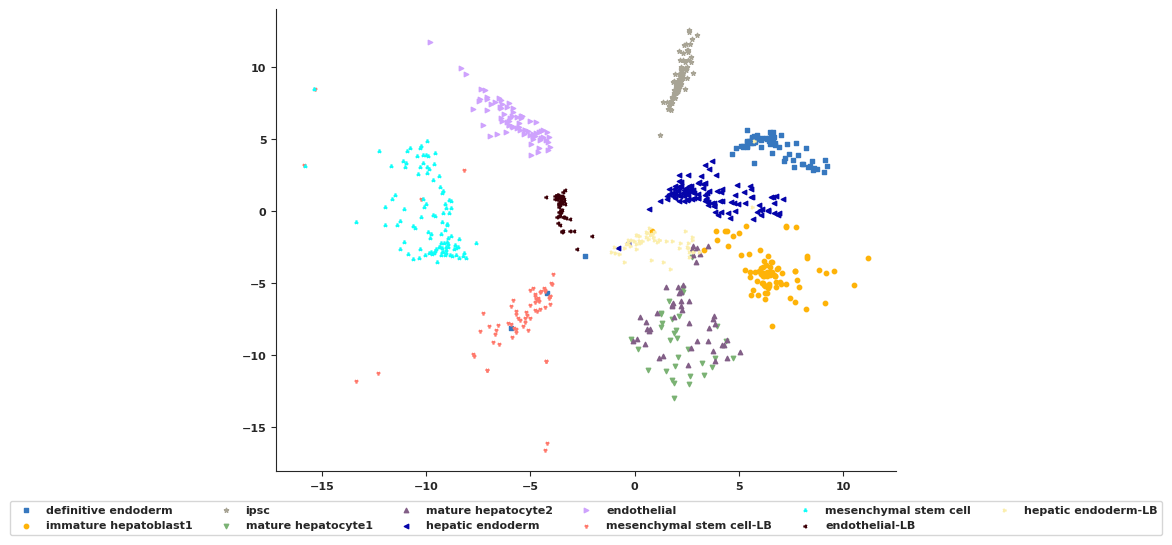

In [ ]:
fig = print_2D(points=res, label=label, id_map=id_map)
fig.show()

In [ ]:
adata.obsm['X_infomax'] = res
adata.write("/content/drive/MyDrive/Thesis/Implement/Experiment/Result/camp_res_10.h5ad")